In [1]:
%matplotlib inline
from lib.my_gapp import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import quad, dblquad

# 强透镜

## LCDM 模型

In [2]:
sldat = np.loadtxt('/home/ekli/myworks/cosmodata/strong_lens_obs.txt', unpack=True)

def lcdm_hz(z,omm=0.3,h0=70,omk=0.0):
    return h0*np.sqrt(omm*(1+z)**3+(1-omm-omk)+omk*(1+z)**2)

def lcdm_dz(z,omm=0.3,h0=70,omk=0.0):
    func = lambda x: 1/lcdm_hz(x,omm,h0,omk)
    dz = np.array([quad(func, 0.0, zi)[0] for zi in z])
    
    if(omk > 1e-8):
        return 1/np.sqrt(omk)*np.sinh(h0*np.sqrt(omk) *dz)
    if(omk < -1e-8):
        return 1/np.sqrt(-omk)*np.sin(h0*np.sqrt(-omk) *dz)
    return h0*dz

def lcdm_dls(zl,zs,omm=0.3,h0=70,omk=0.0):
    dl = lcdm_dz(zl,omm,h0,omk)
    ds = lcdm_dz(zs,omm,h0,omk)
    return np.sqrt(1+omk*ds**2) - dl*np.sqrt(1+omk*ds**2)

def sl_loglike(omk):
    chisq = (sldat[6]-lcdm_dls(sldat[0],sldat[1],omk=omk))**2/sldat[7]**2
    return -0.5*np.sum(chisq)

In [3]:
omk = np.linspace(-1,1,101)

like = np.array([sl_loglike(ok) for ok in omk])

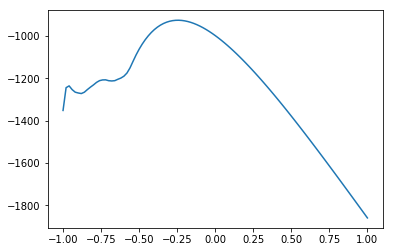

In [4]:
plt.plot(omk, like)

## OHD 重构

In [5]:
initial_cosmo_gp(0)

0

In [14]:
dcl = np.array([gp_dimles_comdistance(z) for z in sldat[0]])
dcs = np.array([gp_dimles_comdistance(z) for z in sldat[1]])

def rofchi(chi,omk):
    fk = np.sqrt(np.abs(omk))
    if(omk >0):
        return 1/fk * np.sinh(fk*chi)
    elif(omk<0):
        return 1/fk*np.sin(fk*chi)
    else:
        return chi
    
dl = lambda omk: rofchi(dcl, omk)
ds = lambda omk: rofchi(dcs, omk)
dls = lambda omk: ds(omk) * np.sqrt(1+omk*dl(omk)**2) - dl(omk) * np.sqrt(1+omk*ds(omk)**2)

def sl_loglike_ohd(omk):
    chisq = (sldat[6]-dls(omk)/ds(omk))**2/sldat[7]**2
    return -0.5*np.sum(chisq)

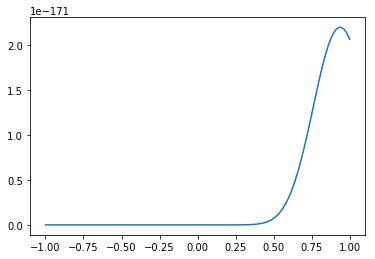

In [18]:
like = np.array([sl_loglike_ohd(ok) for ok in omk])

plt.plot(omk, np.exp(like))

## Pantheon 重构

In [19]:
sn_dz = np.loadtxt('./data/SL_mean_obs.txt', unpack=True)
sn_dz.shape

(6, 205)

In [65]:
Mb = 22;
dl = sn_dz[2]/10**(0.2*Mb)
ds = sn_dz[3]/10**(0.2*Mb)
dls = lambda omk: ds * np.sqrt(1+omk*dl**2) - dl * np.sqrt(1+omk*ds**2)

def sl_loglike_pan(omk, fe=1.01):
    chisq = (sldat[6]-fe**2*dls(omk)/ds)**2/sldat[7]**2
    return -0.5*np.sum(chisq)

/home/ekli/.local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


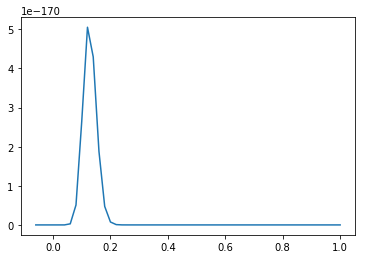

In [66]:
like = np.array([sl_loglike_pan(ok) for ok in omk])

#plt.plot(omk, np.exp(like))
plt.plot(omk, np.exp(like))